In [1]:
from matplotlib import pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [3]:
LATENT_DIM = 2
NEPOCHS = 60
BATCH_SIZE = 256
LEARNING_RATE = 0.001

DC_OUT_DIM = 500
DC_NEPOCHS = 5
DC_NBATCHES = 20

EMBEDDINGS_DIR = "./data/MNIST/embeddings"
EMBEDDINGS = {
    500: {
        "embeddings": os.path.join(EMBEDDINGS_DIR, "embeddings_dcnet_500.pt"),
        "targets": os.path.join(EMBEDDINGS_DIR, "targets_dcnet_500.pt")
    },
    1000: {
        "embeddings": os.path.join(EMBEDDINGS_DIR, "DCNet_embeddings1000.pt"),
        "targets": os.path.join(EMBEDDINGS_DIR, "DCNet_embeddings1000_targets.pt") 
    }
}

In [4]:
mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [5]:
class EmbeddingsDCNet(Dataset):
    def __init__(self, out_dim: int) -> None:
        super().__init__()
        self.embeddings = torch.load(EMBEDDINGS[out_dim]["embeddings"])
        self.targets = torch.load(EMBEDDINGS[out_dim]["targets"])
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, index):
        return self.embeddings[index], self.targets[index]
    
class TripletEmbeddingsDCNet(Dataset):
    def __init__(self, out_dim: int):
        super().__init__()
        self.embeddings = torch.load(EMBEDDINGS[out_dim]["embeddings"])
        self.targets = torch.load(EMBEDDINGS[out_dim]["targets"])
        
    def __len__(self):
        return(len(self.embeddings))
    
    def __getitem__(self, index):
        return self.embeddings[index], self.embeddings[self._pos_idx(index)], self.embeddings[self._neg_idx(index)]
        
    
    def _pos_idx(self, index):
        all_pos_idxs = (self.targets == self.targets[index]).nonzero().flatten()
        rand_idx = torch.randint(len(all_pos_idxs),(1,))
        return all_pos_idxs[rand_idx].item()
        
    
    def _neg_idx(self, index):
        all_neg_idxs = (self.targets != self.targets[index]).nonzero().flatten()
        rand_idx = torch.randint(len(all_neg_idxs),(1,))
        return all_neg_idxs[rand_idx].item()

In [6]:
class TripetLoss(nn.Module):
    def __init__(self, margin: float):
        super().__init__()
        self.margin = margin
        
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        dist_positive = self.distance(anchor, positive)
        dist_negative = self.distance(anchor, negative)
        loss = torch.relu(dist_positive - dist_negative + self.margin)
        return loss.mean()
    
    @staticmethod
    def distance(x: torch.Tensor, y: torch.Tensor):
        return (x - y).pow(2).sum(dim=1)

class SiameseNetwork(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, 128)
        self. relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        
    def forward(self, input: torch.Tensor):
        x_ = self.linear1(input)
        x_ = self.relu1(x_)
        x_ = self.linear2(x_)
        x_f = self.relu2(x_)
        return x_f

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

siamese_net = SiameseNetwork(DC_OUT_DIM)

#THRESHOLDS = [0.4, 0.3, 0.2, 0.15, 0.125] best values
THRESHOLDS = [0.4, 0.3, 0.2, 0.15, 0.1]
MARGIN = 1

loss_fn = TripetLoss(margin=MARGIN)
optimizer_dc = torch.optim.Adam(siamese_net.parameters(), lr=LEARNING_RATE)

triplet_dataset = TripletEmbeddingsDCNet(out_dim=DC_OUT_DIM)

shuffled_index = torch.randperm(len(triplet_dataset))
split = int(0.8*len(triplet_dataset))
train_indexes, test_indexes = shuffled_index[:split], shuffled_index[split:]

embedding_loader = DataLoader(triplet_dataset, batch_size=10*BATCH_SIZE, sampler=SubsetRandomSampler(train_indexes))
test_loader = DataLoader(EmbeddingsDCNet(out_dim=DC_OUT_DIM), batch_size=10*BATCH_SIZE, sampler=SubsetRandomSampler(test_indexes))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
siamese_net.to(device)

print(device)

cpu


In [8]:
from plotting import LossPlotter
plotter = LossPlotter()

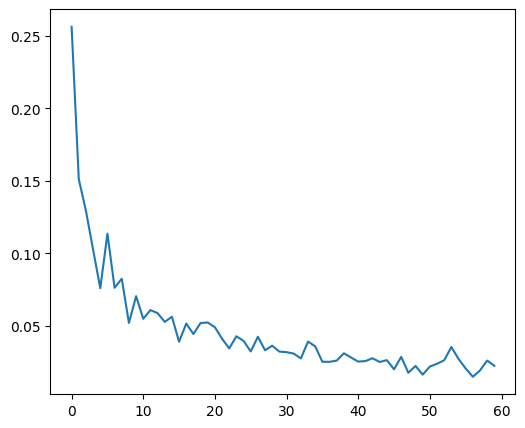

In [9]:
from layers import SequentialAttention
attention_layers = SequentialAttention(DC_OUT_DIM, nlayers=len(THRESHOLDS), thresholds=THRESHOLDS, strengths=0.2)

siamese_net.train()

for epoch in range(NEPOCHS):
    running_loss = 0
    for anchors, positivies, negatives in tqdm(embedding_loader, total=len(embedding_loader), desc=f"Epoch:{epoch+1}/{NEPOCHS}"):
        anchors_out = attention_layers(anchors)
        positivies_out = attention_layers(positivies)
        negatives_out = attention_layers(negatives)
        
        anchors_out.to(device)
        positivies_out.to(device)
        negatives_out.to(device)
            
        optimizer_dc.zero_grad()
        
        anchors_out = siamese_net(anchors_out)
        positivies_out = siamese_net(positivies_out)
        negatives_out = siamese_net(negatives_out)
            
        loss = loss_fn(anchors_out, positivies_out, negatives_out)
            
        loss.backward()
        optimizer_dc.step()
        
    plotter(loss.item())

In [10]:
print(attention_layers.nkeys)

[2301, 550, 137, 78, 39]


In [11]:
siamese_net.eval()

inputs_dc, attention_dc, latents_dc, targets_dc = [], [], [], []

with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader)):
        inputs_dc.append(data)
        targets_dc.append(target)
        embeddings_dc = attention_layers(data, train=False)
        attention_dc.append(embeddings_dc)
    
        embeddings_dc.to(device)
        
        siamese_output = siamese_net(embeddings_dc)
        
        latents_dc.append(siamese_output.cpu())

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


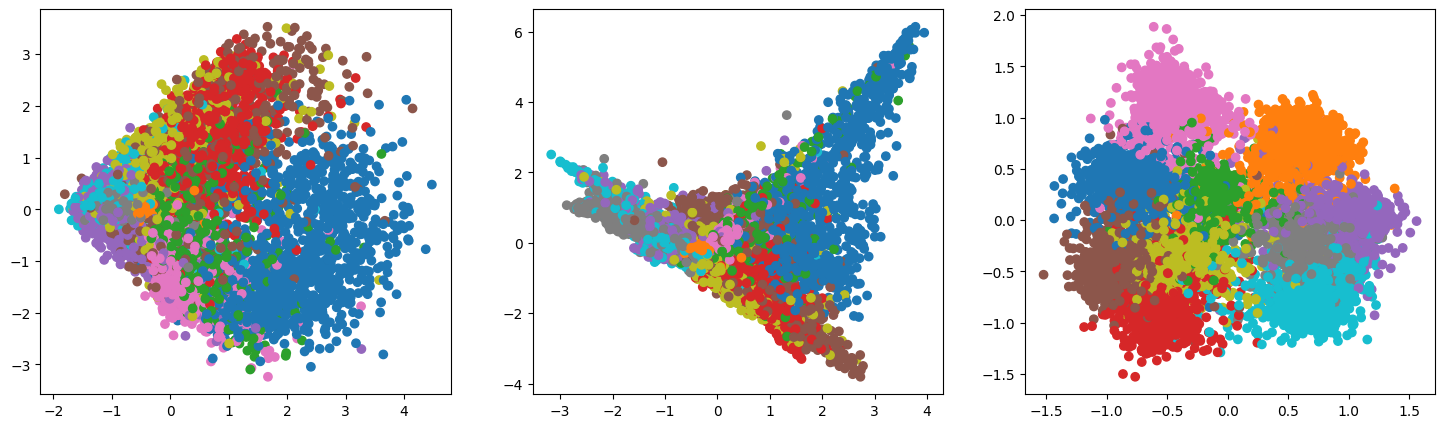

In [12]:
from sklearn.decomposition import PCA

latents_combined_dc = torch.empty(0)
attention_combined_dc = torch.empty(0)
inputs_combined_dc = torch.empty(0)
targets_combined_dc = torch.empty(0)
for latent, attention, input, target in zip(latents_dc, attention_dc, inputs_dc, targets_dc):
    latents_combined_dc = torch.cat((latents_combined_dc, latent), dim=0)
    attention_combined_dc = torch.cat((attention_combined_dc, attention), dim=0)
    inputs_combined_dc = torch.cat((inputs_combined_dc, input), dim=0)
    targets_combined_dc = torch.cat((targets_combined_dc, target), dim=0)
    
latent_projections_dc = PCA(n_components=2).fit_transform(latents_combined_dc)
input_projections_dc = PCA(n_components=2).fit_transform(inputs_combined_dc)
input_projections_dc /= torch.std(torch.tensor(input_projections_dc), dim=0, keepdim=True).numpy()
attention_projections_dc = PCA(n_components=2).fit_transform(attention_combined_dc)
attention_projections_dc /= torch.std(torch.tensor(attention_projections_dc), dim=0, keepdim=True).numpy()

fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(input_projections_dc[:,0], input_projections_dc[:,1], c=targets_combined_dc, cmap='tab10')
ax[1].scatter(attention_projections_dc[:,0], attention_projections_dc[:,1], c=targets_combined_dc, cmap='tab10')
ax[2].scatter(latent_projections_dc[:,0], latent_projections_dc[:,1], c=targets_combined_dc, cmap='tab10')

In [ ]:
def relative_positions(points: torch.Tensor) -> torch.Tensor:
    n = points.shape[0]
    relative_positions = torch.zeros(n, n)
    for idx, point in enumerate(points):
        rel_pos = (points - point).sign().sum(dim=1)
        relative_positions[idx,:] = rel_pos
    
    return relative_positions